# Shell Volumes and Distances in High-Dimensional Spaces

>  Given enough dimensions, does it really matter which distance norm you use? 

- toc: true 
- badges: true
- comments: true
- author: Scott H. Hawley
- image: images/softmax_radii.png

Some of us are still not accustomed to thinking in terms of very high numbers of dimensions -- myself included. Earlier this year, I made a post on [vector orthogonality in high-dimensional spaces](https://drscotthawley.github.io/blog/2022/01/24/MultiDim-DotProducts.html). 

This post is about the *volume* of high-dimensional spaces. Even in two dimensions, you may be aware of facts such as that **a 20-inch pizza has more than twice the area of a 14-inch pizza**:

In [ ]:
print("Areas =",[3.14*r**2 for r in [14, 20]])

Areas in square inches = [615.44, 1256.0]


As we go to higher dimensions, such observations become more stark, for example that a sphere of radius 4 has **eight times** the volume of a sphere of radius 2.

## Intuition from Geometry: Volumes of n-balls

Let's consider the [volume of a multidimensional "n-ball"](https://en.wikipedia.org/wiki/Volume_of_an_n-ball) of dimension $n$ and radius $r$, which is given by this recurrence relation:
$$ {\displaystyle V_{n}(r)={\begin{cases}1&{\text{if }}n=0,\\[0.5ex]2r&{\text{if }}n=1,\\[0.5ex]{\dfrac {2\pi }{n}}r^{2}\times V_{n-2}(r)&{\text{otherwise}}.\end{cases}}} $$

So, for example, $V_2(r) = \pi r^2$, $V_3(r) = {2\pi\over 3}r^2\times 2r = {4\over 3}\pi r^3$,...and so on.

Let's consider the *percentage of the total* volume for a shell of thickness $\Delta r$, as a function of both $r$ and $n$.  In the following we're going to plot $V_n(r+\Delta r) - V_n(r)$ as we vary $n$, and let's take steps of size $\Delta r$ = r/10 and let $n=2,3,4$...

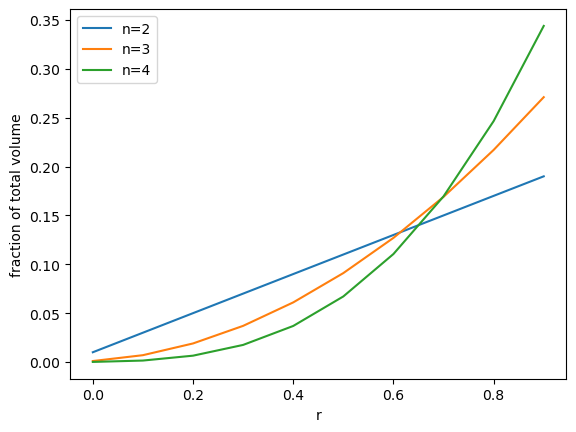

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 

def volume(n, r):
    "a recursive formula for the volume of an n-ball of radius r"
    if 0==n: return 1
    if 1==n: return 2*r
    return 2*np.pi/n * r**2 * volume(n-2, r)

def plot_fractions(ns, dr=1/10):
    rs = np.linspace(0,1-dr,num=int(1/dr)) #we'll let r go from 0 to 1
    #print("rs = ",rs)
    for n in ns:
        v_dr = (volume(n, rs+dr) - volume(n, rs))  # volume of the shell
        fractions = v_dr/volume(n, 1)              # fraction of total volume
        plt.plot(rs, fractions, label=f'n={n}')
        assert 1-np.sum(fractions) < 1e-6, "Error: fractions don't add up to 1"
    plt.legend()
    plt.xlabel('r')
    plt.ylabel('fraction of total volume')
    plt.show()
    
plot_fractions([2,3,4])

If we go to larger numbers of dimensions, we see that almost the entire volume is made up of a thin shell near the perimeter:

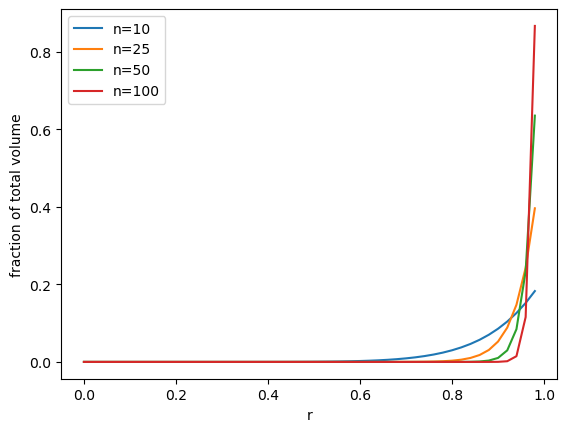

In [ ]:
plot_fractions([10,25,50,100], dr=1/50)

In Deep Learning applications, it's not uncommon to have dimensions $n$ which are 64, 256, even over 1000 dimensions. For data points which populate such a high dimensional n-ball with **uniform density**, essentially all of them will lie "on the surface" of the n-ball. 

We may want to know about the distance between such points.  If they're inside a "volume", we might think than a Euclidean-type distance would be the best.  But if they *pretty much all lie* along the surface of a sphere, would that really be any better or worse that something like an angular distance or the frequently used [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity)? 

Hmmm. Good question. We should consider something else first before we go on. 

## Hold up.  "An n-ball of uniform density": How relevant is that?

That depends. 

Previously we were imagining just the volume of the n-ball itself, then we imagined it being populated "uniformly" by data points.  But is that likely to happen? In other words, if we've got $n$ random variables that are each uniformly distributed on $[0..1]$, then are we saying that the average radius (or distance from the origin) is going to be close to 1? Uh.... let's check: 


In [ ]:
for n in [2,3,4,10,20]:
    x = np.random.rand(n)  # some random vector
    print(f"n = {n}, distance = {np.sqrt(np.sum(x**2))}")

n = 2, distance = 0.4531853366702091
n = 3, distance = 1.0826001130628344
n = 4, distance = 1.2805569079817343
n = 10, distance = 1.965822638795274
n = 20, distance = 2.9421432188892176


...so, no.  We can actually get greater distances than 1 this way. That means that such points are **not within the unit n-ball**. 

But what if these are the kinds of points we're mostly likely to get in our Data Science and Deep Learning investigations?  That depends on our data, and how it may (or may not) be normalized. 

If we have such random, independent variables, which may lie outside the unit n-ball, what can we say about their distances?  Well, the above list of outputs were were just *one vector* for each dimension. Let's take a look a a number (...ah we can't use the letter $n$, let's say) $m$ random vectors in $n$ dimensions...

In [ ]:
ns =  [2,3,4,10,32,64,128,256,512,1024,2048] # number of dimensions
m = 1000  # number of random vectors in each dimension
avg_distances = []
for n in ns:
    x = np.random.rand(m,n)
    distance = np.sqrt(np.sum(x**2, axis=1))
    avg_distance = np.mean(distance)
    print(f"n = {n}, avg distance from origin = {avg_distance}")
    avg_distances.append(avg_distance)

n = 2, avg distance from origin = 0.7481821823467171
n = 3, avg distance from origin = 0.9691494533397342
n = 4, avg distance from origin = 1.124886358111731
n = 10, avg distance from origin = 1.8035216690887792
n = 32, avg distance from origin = 3.261533859767904
n = 64, avg distance from origin = 4.607289814395833
n = 128, avg distance from origin = 6.527956044174336
n = 256, avg distance from origin = 9.238162970649888
n = 512, avg distance from origin = 13.071335971436879
n = 1024, avg distance from origin = 18.464564627923217
n = 2048, avg distance from origin = 26.135526554018735


It kind of looks like a (sideways) parabola!

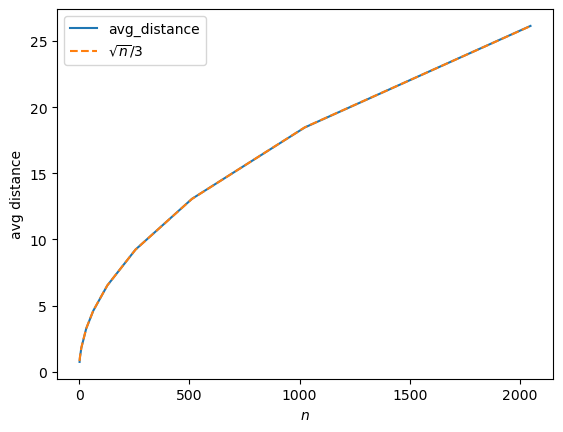

In [ ]:
plt.plot(ns,avg_distances, label='avg_distance')
plt.plot(ns, np.sqrt(np.array(ns)/3), '--', label='$\sqrt{n}/3$') # what if we also plot sqrt(n)* a constant? 
plt.legend()
plt.ylabel('avg distance')
plt.xlabel('$n$')
plt.show()

Now, if we were to *normalize* these points so that they had some similar magnitude, that'd be fine, although if we normalized using the Euclidean norm that would *force* the points to lie on the surface of the n-ball, i.e. an n-sphere.  That's kind of boring, right? ;-) 

More interesting would probably be those points which have been normalized according to the frequently-used [softmax](https://en.wikipedia.org/wiki/Softmax_function) function,

$$ {\rm softmax}(x_i) = {e^{x_i} \over \sum_j e^{x_j}},$$

which will force them to have unit magnitude according to the L1 norm or "[Manhattan Distance](https://en.wikipedia.org/wiki/Taxicab_geometry)" which was the subject of [earlier investigations in this blog](https://drscotthawley.github.io/blog/scottergories/2021/05/04/The-Joy-Of-3D.html). 

So, what we'll do is we'll choose random variables on some interval -- but will they be uniform, Gaussian, or some other choice? -- and then softmax them, and then have a look at their distance from the origin, and **then, more importantly, their distances from each other**. 

n = 2, avg distance from origin = 0.0007511397255709152
n = 3, avg distance from origin = 0.0006308267488890856
n = 4, avg distance from origin = 0.0005510334461844213
n = 10, avg distance from origin = 0.00035750458935601627
n = 32, avg distance from origin = 0.00020173684564505517
n = 64, avg distance from origin = 0.00014270354448691296
n = 128, avg distance from origin = 0.00010118972374124984
n = 256, avg distance from origin = 7.159922929099627e-05
n = 512, avg distance from origin = 5.064894541153353e-05
n = 1024, avg distance from origin = 3.579446707831397e-05
n = 2048, avg distance from origin = 2.5317769100231054e-05


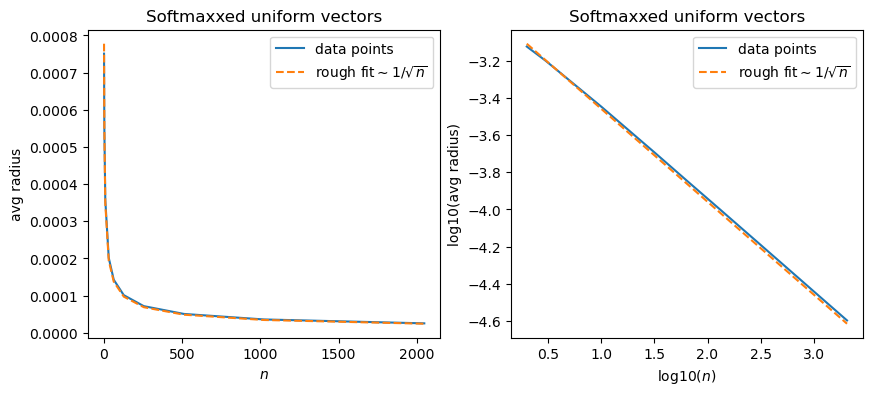

In [ ]:
def softmax(x):
    xmax = np.max(x) # this little trick can help with numerical accuracy
    return np.exp(x-xmax) / np.sum(np.exp(x - xmax))


ns =  [2,3,4,10,32,64,128,256,512,1024,2048] # number of dimensions
m = 1000  # number of random vectors in each dimension
avg_distances = []
for n in ns:
    x = 2*np.random.rand(m,n)-1  # let each value vary on -1..1 before we softmax them
    x = softmax(x)               # softmax will force everything to have L1 norm = 1
    distance = np.sqrt(np.sum(x**2, axis=1)) # measure distance according to L2/Euclidean norm
    avg_distance = np.mean(distance)
    print(f"n = {n}, avg distance from origin = {avg_distance}")
    avg_distances.append(avg_distance)

ns, avg_distances = np.array(ns), np.array(avg_distances)
fit = 11e-4/ns**(1/2)
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(ns,avg_distances, label='data points')
ax[0].plot(ns,fit, '--', label='rough fit$\sim 1/\sqrt{n}$')
ax[1].plot(np.log10(ns),np.log10(avg_distances), label='data points')
ax[1].plot(np.log10(ns),np.log10(fit), '--', label='rough fit$\sim 1/\sqrt{n}$')

ax[0].set_ylabel('avg radius')
ax[0].set_xlabel('$n$')
ax[1].set_ylabel('log10(avg radius)')
ax[1].set_xlabel('log10($n$)')
for i in [0,1]: 
    ax[i].legend()
    ax[i].set_title("Softmaxxed uniform vectors")
plt.show()

So does this mean that for larger numbers of dimensions, the "softmaxxed" points tend to get **closer to the origin, rather than the perimeter**?  Well, not necessarily from these graphs alone.  These are showing the *average*, which could be distorted by large values, for example.  So let's do a series of plots for different values of $n$. 

....**TODO.** I'll need to come back and fill this in later.  
For now, it's an exercise for the student/professor. ;-) 